In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from functions import *
import json

In [2]:
input_file = 'PNAS_8worm_dataset.mat'
cmap = get_colormap()

worm_dicts = read_input_mat_file(input_file, style = 1)
averaged_results = calculate_metrics(worm_dicts, use_annotations = True, return_average = True)

100%|██████████| 8/8 [00:38<00:00,  4.82s/it]


In [3]:
pairs = list(set(averaged_results.keys()))

## all neurons including AVAR, AVAL, etc
# all_neurons = list(set([item for sublist in pairs for item in sublist]))
# all_neurons.sort()

## to replicate the results in the paper
# all_neurons = ['VA05', 'VA06', 'VA07', 'DA07', 'DA08', 'VA04', 'DA09', 'DA02', 'VA02', 'DA03', 'VA01', 'DA01', 'DA06', 'DA04', 'VA08', 'DA05', 'VA11', 'VA09', 'VA10', 'VA03', 'VA12']
all_neurons = ['DA02', 'VA02', 'VA03', 'DA03', 'DA01', 'DA08', 'DA09', 'VA12', 'VA07', 'VA05', 'VA04', 'VA06', 'DA07', 'VA01', 'VA09', 'VA10', 'VA11', 'DA05', 'DA04', 'VA08', 'DA06']
# all_neurons = ['VA04', 'VA05', 'VA06', 'VA02', 'DA08', 'VA07', 'DA02', 'DA09', 'VA03', 'VA11', 'VA12', 'VA08', 'VA09', 'VA10', 'DA03', 'DA04', 'DA07', 'DA01', 'DA05', 'VA01', 'DA06']

mapping_neuron_to_idx = {all_neurons[idx]:idx for idx in range(len(all_neurons))}
mapping_idx_to_neuron = {idx:all_neurons[idx] for idx in range(len(all_neurons))}

In [4]:
matrices = {}
modified_matrices = {}

for metric in averaged_results[pairs[0]]:
    matrix = np.ones((len(mapping_neuron_to_idx), len(mapping_neuron_to_idx)))
    for pair in pairs:
        if pair[0] in mapping_neuron_to_idx and pair[1] in mapping_neuron_to_idx:
            matrix[mapping_neuron_to_idx[pair[0]], mapping_neuron_to_idx[pair[1]]] = averaged_results[pair][metric]
            matrix[mapping_neuron_to_idx[pair[1]], mapping_neuron_to_idx[pair[0]]] = averaged_results[pair][metric]
    
    threshold = calculate_percolation(matrix)
    modified_matrix = np.where(matrix >= threshold, matrix, 0)
    
    matrices[metric] = matrix
    modified_matrices[metric] = modified_matrix

In [5]:
modified_matrices.keys()

dict_keys(['pearson', 'spearman', 'kendall', 'distance', 'covariance', 'los_0.01', 'los_0.015', 'los_0.02', 'los_0.025', 'los_0.03', 'los_0.035', 'los_0.04', 'los_0.045000000000000005', 'los_0.05', 'los_0.055', 'los_0.060000000000000005', 'los_0.065', 'los_0.06999999999999999', 'los_0.075', 'los_0.08', 'los_0.08499999999999999', 'los_0.09', 'los_0.095', 'los_0.09999999999999999', 'los_0.105', 'los_0.11', 'los_0.11499999999999999', 'los_0.12', 'los_0.125', 'los_0.13', 'los_0.135', 'los_0.14', 'los_0.14500000000000002', 'los_0.15000000000000002', 'los_0.155', 'los_0.16', 'los_0.165', 'los_0.17', 'los_0.17500000000000002', 'los_0.18000000000000002', 'los_0.18500000000000003', 'los_0.19', 'los_0.195', 'los_0.2'])

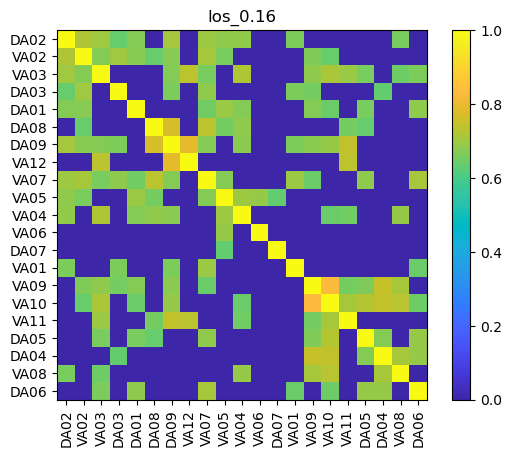

In [6]:
metric = 'los_0.16'
# metric = 'pearson'
plt.imshow(modified_matrices[metric], cmap=cmap, vmin=0, vmax=1)
plt.xticks(range(len(all_neurons)), all_neurons, rotation=90)
plt.yticks(range(len(all_neurons)), all_neurons)
plt.title(metric)
plt.colorbar();

In [7]:
all_cliques = []

# for metric, matrix in tqdm(modified_matrices.items(), total=len(modified_matrices)):
#     # valid_cliques = check_cliques_struc_v2(matrix, all_neurons, 2, 9)
#     # refined_cliques = refine_cliques(valid_cliques)
#     louvain_results = louvain_clustering_best_modularity(matrix, all_neurons, 100)
    
#     # all_cliques.append(refined_cliques)
#     all_cliques.append(louvain_results)

louvain_results = louvain_clustering_best_modularity(modified_matrices[metric], all_neurons, 100)
all_cliques.append(louvain_results)

In [8]:
with open('colorings/louv_los_16_colors.txt', 'w') as f:
    for idx, clique in enumerate(louvain_results):
        for node in clique:
            print(f'{node}\t{idx}', file=f)
        
    print(f'AVEL\t{idx+1}', file=f)
    print(f'AVER\t{idx+1}', file=f)
    
    print(f'AVDL\t{idx+2}', file=f)
    print(f'AVDR\t{idx+2}', file=f)
    
    print(f'AVAL\t{idx+3}', file=f)
    print(f'AVAR\t{idx+3}', file=f)

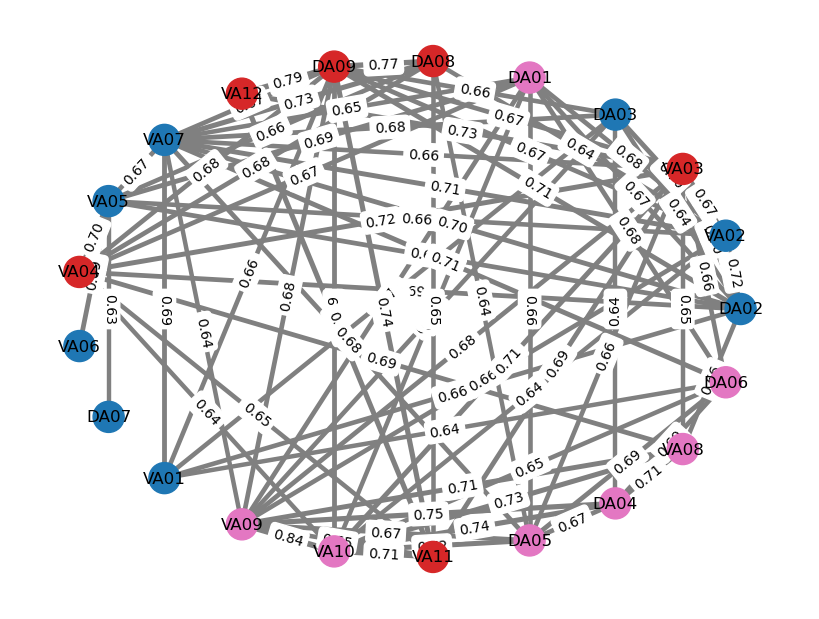

In [9]:
plot_graph_with_weights_and_groups(modified_matrices['los_0.16'], all_neurons, louvain_results)

In [10]:
# # Convert the list to a JSON string
# json_string = json.dumps(all_cliques)

# # Save the JSON string to a file
# with open("all_cliques.json", "w") as f:
#     f.write(json_string)
    
with open('all_cliques.json', 'r') as file:
    # Load the JSON data from the file
    all_cliques = json.load(file)

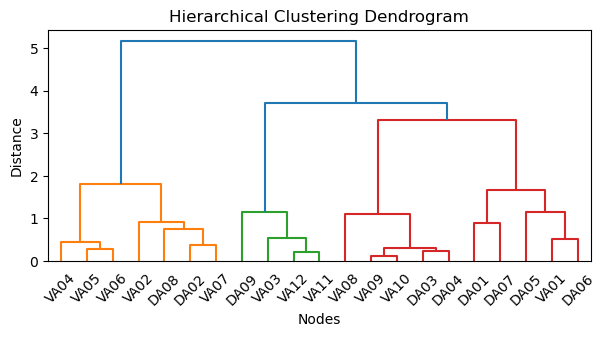

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

cooccurrence_matrix = get_cooccurrence_matrix(all_cliques, mapping_neuron_to_idx)

# Step 4: Perform Hierarchical Clustering using Ward's Method
linkage_matrix = linkage(cooccurrence_matrix, method='ward')

# Step 5: Plot the Dendrogram
plt.figure(figsize=(7, 3))
dendo = dendrogram(linkage_matrix, labels=all_neurons)
cooccurrence_matrix = cooccurrence_matrix[np.ix_(dendo['leaves'], dendo['leaves'])]
new_node_order = [all_neurons[node] for node in dendo['leaves']]
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Nodes")
plt.ylabel("Distance")
plt.show()

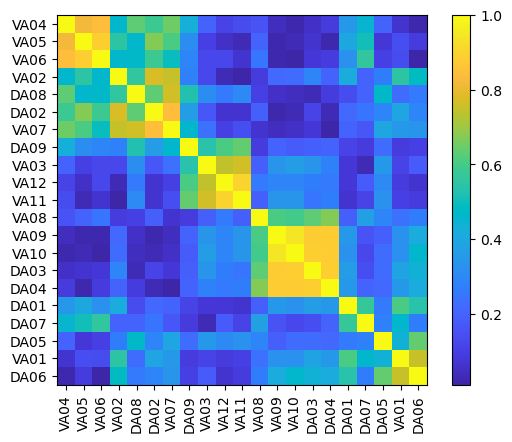

In [12]:
plt.imshow(cooccurrence_matrix, cmap=cmap)
plt.xticks(range(len(new_node_order)), new_node_order, rotation=90)
plt.yticks(range(len(new_node_order)), new_node_order)
plt.colorbar();

In [13]:
for n_cluster in [3,4,5,6,7,8,9,10]:
    clusters = fcluster(linkage_matrix, n_cluster, criterion='maxclust')

    with open(f'colorings/cons_{n_cluster}_colors.txt', 'w') as f:
        for idx, neuron in enumerate(all_neurons):
            print(f'{neuron}\t{clusters[idx]}', file=f)
            
        print(f'AVEL\t{clusters[idx]+1}', file=f)
        print(f'AVER\t{clusters[idx]+1}', file=f)
        
        print(f'AVDL\t{clusters[idx]+2}', file=f)
        print(f'AVDR\t{clusters[idx]+2}', file=f)
        
        print(f'AVAL\t{clusters[idx]+3}', file=f)
        print(f'AVAR\t{clusters[idx]+3}', file=f)

In [1]:
from graph_repair import repair_network

In [ ]:
EdgesRemoved,EdgesAdded, G_result = repair_network("colorings/cons_5_colors.txt", "connectomes/collapsed_varshney.graph.txt", "collapsed_cons_5_colors_o_", 1, 2)

#######TIME TO SET UP#######

Reading data from connectomes/collapsed_varshney.graph.txt and colorings/cons_5_colors.txt
Read graph: n=23 m=56
Read colors
Created tuples
created all pairs
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2598042
Academic license 2598042 - for non-commercial use only - registered to ah___@gradcenter.cuny.edu
Creating model
0.2877078056335449
Set parameter MIPGap to value 0.1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0.1

Academic license 2598042 - for non-commercial use only - registered to ah___@gradcenter.cuny.edu
Optimize a model with 8548 rows, 6583 columns and 56210 nonzeros
Model fingerprint: 0xd2baa6b4
Model has 313 simple general constraints
  313 ABS
Variable types: 77 continuous, 5880 integer (5880 binary)
Semi-Variable types: 0 continuous, 6